# Determinants of Box Office Success

## Imports

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.stats import iqr

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
movies = pd.read_csv('movie_data.csv')

## Explore and Clean Dataset

**Numeric variables:** num_critic_reviews, duration, director_facebook_likes, actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes, movie_facebook_likes, gross, num_users_voted (int), cast_total_facebook_likes  (int), num_user_reviews, budget, title_year , movie_score, aspect_ratio (int)  <br>
**Categorical variables:** color, director_name, actor_1_name, actor_2_name, actor_3_name, genres, plot_keywords, language, country, content_rating

In [3]:
# remove missing values
movies.dropna(inplace=True)

# remove duplicate rows based on the 'movie_title' column
movies.drop_duplicates(subset=['movie_title'], keep=False, inplace=True)

# reset index
movies.reset_index(drop=True, inplace=True)

In [4]:
# transform budget and gross metrics
movies['budget_millions'] = round(movies['budget'] / 1000000, 4)
movies['gross_millions'] = round(movies['gross'] / 1000000, 4)

# add calcuated columns
movies['profit_millions'] = movies['gross_millions'] - movies['budget_millions']
movies['roi'] = round((movies['profit_millions'] / movies['budget_millions']), 4)
movies['profit_margin'] = movies['profit_millions'] / movies['gross_millions']

movies['budget_millions'] = movies['budget_millions'].replace(0, np.NaN)
movies['gross_millions'] = movies['gross_millions'].replace(0,np.NaN)

#movies.to_csv('movies_pm_roi.csv')

### Remove irrelevant movies
All movies released prior to 1996 are removed; all non-English language movies are removed

In [5]:
# remove all movies from before the year 1996 in order to focus on the most recent data points
movies = movies[movies['title_year']>=1996]

# keep only English language movies
movies = movies[movies['language'] == 'English']

movies.reset_index(drop=True, inplace=True)

### Explore Numeric Variables

Several of the numeric variables have significant outliers that will make it more difficult to accurately assess relationships between variables. 

**Solution** - trim numeric variables by replacing outliers with upper whisker values.

**Method** - outliers are identified using the IQR method; replace outliers with upper whisker value; trimmed values are stored in a separate dataframe (movies_trimmed)

In [6]:
# define movies trimmed to hold trimmed variables
movies_trimmed = movies.copy(deep = True)

In [7]:
# separate numerical fields from categorical
movies_numeric = movies.select_dtypes(include=['float64', 'int64'])

# replace outliers with upper whisker / lower whisker value
for column in movies_numeric:
    q1 = movies_trimmed[column].quantile(0.25)
    q3 = movies_trimmed[column].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + (iqr*1.5)
    lower_whisker = q1 - (iqr*1.5)
    movies_trimmed.loc[movies_trimmed[column] > upper_whisker, column] = upper_whisker
    movies_trimmed.loc[movies_trimmed[column] < lower_whisker, column] = lower_whisker

In [8]:
#boxplot = movies_trimmed.boxplot(column=['duration'])
#boxplot = movies_trimmed.boxplot(column=['movie_score'])
#boxplot = movies_trimmed.boxplot(column=['num_critic_reviews'])

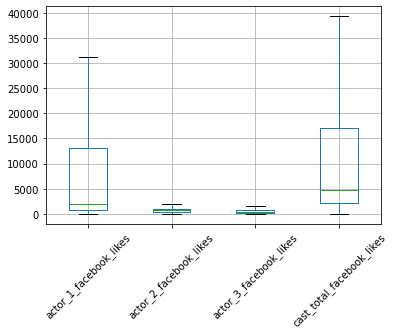

In [9]:
# boxplot showing facebook likes for actors
boxplot = movies_trimmed.boxplot(column=['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes'], rot=45)

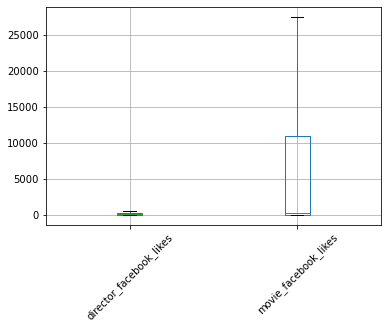

In [10]:
# boxplot showing facebook likes for directors and movies
boxplot = movies_trimmed.boxplot(column=['director_facebook_likes','movie_facebook_likes'], rot=45)

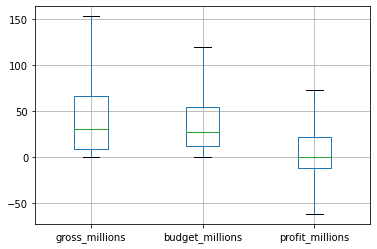

In [11]:
# boxplot showing financial variables
boxplot = movies_trimmed.boxplot(column=['gross_millions','budget_millions','profit_millions'])

In [12]:
mean_profit = movies['profit_millions'].mean()
mean_gross = movies['gross_millions'].mean()

### Explore Categorical Variables

In [13]:
movies['director_name'].value_counts()

Woody Allen          15
Steven Spielberg     15
Clint Eastwood       14
Steven Soderbergh    13
Ridley Scott         12
                     ..
Cal Brunker           1
Frank Whaley          1
Chris Nahon           1
Richard Glatzer       1
Hal Haberman          1
Name: director_name, Length: 1392, dtype: int64

In [14]:
movies['actor_1_name'].value_counts()

Robert De Niro       31
J.K. Simmons         27
Matt Damon           26
Nicolas Cage         25
Robert Downey Jr.    24
                     ..
David Hewlett         1
Steve Irwin           1
Carlos Ponce          1
Oliver James          1
Matt Bennett          1
Name: actor_1_name, Length: 1113, dtype: int64

In [15]:
movies['actor_2_name'].value_counts()

Morgan Freeman        13
Charlize Theron       12
Brad Pitt             10
Will Ferrell           9
James Franco           9
                      ..
Lola Glaudini          1
Christian Stolte       1
Mike White             1
Wendie Malick          1
Charlotte Rampling     1
Name: actor_2_name, Length: 1742, dtype: int64

In [16]:
movies['actor_3_name'].value_counts()

Steve Coogan         8
Bruce McGill         6
Thomas Lennon        6
Stephen Root         6
Steve Carell         6
                    ..
Stephen Merchant     1
Moises Arias         1
Jaqueline Fleming    1
Leon                 1
Wade Williams        1
Name: actor_3_name, Length: 2064, dtype: int64

In [17]:
movies['plot_keywords'].value_counts()

# plot keywords will be more effectively analyzed by separating the keywords

gang|gangster|subjective camera|written and directed by cast member|yakuza    1
corndog|failure|funeral in the rain|new york city|weatherman                  1
freight train|race against time|runaway train|train|train engineer            1
divorce|female frontal nudity|future|loneliness|operating system              1
box office flop|ronin|samurai|shogun|tournament                               1
                                                                             ..
evil|goblin|spider|spider man|superhero                                       1
claim in title|infidelity|irish american|love|sex                             1
deputy|farmhouse|nightmare|private investigator|rural                         1
accident|diary|ghost|psychic|veterinarian                                     1
actor|love|movie star|press|publicist                                         1
Name: plot_keywords, Length: 2885, dtype: int64

In [18]:
movies['country'].value_counts()

USA               2385
UK                 229
Germany             65
France              64
Canada              52
Australia           26
Spain               14
Ireland              7
New Zealand          6
Denmark              5
Hong Kong            4
South Korea          3
Japan                3
South Africa         3
Italy                3
Czech Republic       2
Iceland              1
Greece               1
New Line             1
Poland               1
Belgium              1
Aruba                1
Thailand             1
Russia               1
Hungary              1
Georgia              1
Official site        1
Chile                1
Romania              1
China                1
Name: country, dtype: int64

In [19]:
movies['content_rating'].value_counts()

R            1290
PG-13        1092
PG            406
G              63
Not Rated      18
Unrated        12
NC-17           4
Name: content_rating, dtype: int64

In [20]:
movies['key_actors'] = movies['actor_1_name'].map(str) + '-' + movies['actor_2_name'].map(str) + '-' + movies['actor_3_name'].map(str)
movies['key_actors']

0              CCH Pounder-Joel David Moore-Wes Studi
1            Johnny Depp-Orlando Bloom-Jack Davenport
2       Christoph Waltz-Rory Kinnear-Stephanie Sigman
3       Tom Hardy-Christian Bale-Joseph Gordon-Levitt
4           Daryl Sabara-Samantha Morton-Polly Walker
                            ...                      
2880      Paul Schneider-Eddie Rouse-Damian Jewan Lee
2881        Derick Martini-Christa Miller-Ion Overman
2882            Stacy Edwards-Matt Malloy-Jason Dixie
2883        Shane Carruth-David Sullivan-Casey Gooden
2884            John August-Brian Herzlinger-Jon Gunn
Name: key_actors, Length: 2885, dtype: object

### Explore Relationships in the Data

**Variables that are moderately correlated (correlation > 0.4) with gross revenue:** num_critic_reviews, num_users_voted, num_user_reviews, budget, profit_millions, roi, profit_margin 
<br>
**Variables that are moderately correlated (correlation > 0.4) with profit:** gross_millions, num_users_voted, roi, profit_margin
<br>
**Variables that are moderately correlated (correlation > 0.4) with profit margin:** gross_millions, roi, profit_margin
<br>
**Variables that are moderately correlated (correlation > 0.4) with ROI:** gross_millions, profit_millions, profit_margin

In [21]:
corr_matrix_trimmed = movies_trimmed.corr()
corr_matrix_trimmed.to_csv('corr_matrix_trimmed.csv')

corr_matrix_trimmed

,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_users_voted,cast_total_facebook_likes,num_user_reviews,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,budget_millions,gross_millions,profit_millions,roi,profit_margin
num_critic_reviews,1.000000,0.342007,0.260540,0.203297,0.306828,0.468421,0.731484,0.320250,0.641283,0.390290,0.533642,0.255204,0.438234,0.244230,0.711135,0.390290,0.468421,0.239840,0.207010,0.272728
duration,0.342007,1.000000,0.279712,0.180840,0.251282,0.284007,0.407486,0.263182,0.430204,0.359339,0.028947,0.210649,0.405586,0.274454,0.265055,0.359339,0.284007,0.034023,-0.038322,0.031689
director_facebook_likes,0.260540,0.279712,1.000000,0.080624,0.169594,0.159314,0.275338,0.164894,0.260489,0.191359,0.012941,0.105992,0.243510,0.116658,0.180845,0.191359,0.159314,0.018923,0.012067,0.049003
actor_3_facebook_likes,0.203297,0.180840,0.080624,1.000000,0.457013,0.299079,0.260407,0.614249,0.198525,0.285447,0.075708,0.764108,0.050810,0.085667,0.181419,0.285447,0.299079,0.139454,0.038524,0.134176
actor_1_facebook_likes,0.306828,0.251282,0.169594,0.457013,1.000000,0.234177,0.356501,0.949536,0.251123,0.270241,0.126885,0.575360,0.220865,0.162111,0.251933,0.270241,0.234177,0.051218,0.002077,0.077789
gross,0.468421,0.284007,0.159314,0.299079,0.234177,1.000000,0.678198,0.275303,0.548891,0.698069,0.106414,0.304119,0.217524,0.117558,0.314723,0.698069,1.000000,0.646815,0.425286,0.523877
num_users_voted,0.731484,0.407486,0.275338,0.260407,0.356501,0.678198,1.000000,0.372880,0.812196,0.502887,0.147753,0.313899,0.528849,0.178639,0.539092,0.502887,0.678198,0.427362,0.299402,0.369899
cast_total_facebook_likes,0.320250,0.263182,0.164894,0.614249,0.949536,0.275303,0.372880,1.000000,0.265089,0.302708,0.137308,0.728906,0.208624,0.154215,0.270540,0.302708,0.275303,0.080903,0.012476,0.094401
num_user_reviews,0.641283,0.430204,0.260489,0.198525,0.251123,0.548891,0.812196,0.265089,1.000000,0.435769,-0.028604,0.229037,0.398325,0.170865,0.360015,0.435769,0.548891,0.315828,0.260695,0.333228
budget,0.390290,0.359339,0.191359,0.285447,0.270241,0.698069,0.502887,0.302708,0.435769,1.000000,0.089184,0.314703,0.079945,0.226168,0.226584,1.000000,0.698069,-0.039650,-0.152262,0.096608


## Actor Analysis
<br>
Do certain director's tend to make more successful movies?

### VAR (Value Above Replacement) / percent above mean
Value above replacement / percent above mean demonstrates how much a vaue differs from the average value. 
<br>
<br>
**Method**: (1) filter df to show only actors who have appeared in at least 4 movies; (2) calculate average profit per actor; (3) divide average profit per actor by overall average profit for all actors who have appeared in at least 4 movies
<br>
<br>
**Result**: There are 58 main actors(actor1), 28 key supporting actors (actor2), and 47 additional supporting actors (actor3) with a VAR greater than 2 - indicating that the movies these actors act in have an average profit that is at least 200% above the overall average. There is some overalp between the three lists.

In [45]:
#calculating VAR for actors/actresses
actor1_counts = movies['actor_1_name'].value_counts()

#creating a list with a condition of having appeared in at least 4 movies
actor1_list = actor1_counts[actor1_counts >= 4].index.tolist()

#creating a dataframe with actors in 4 or more movies
actors1 = movies[movies['actor_1_name'].isin(actor1_list)]

#creating a dataframe with actors and the average profit
actor1_total = actors1.groupby(['actor_1_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

#creating the VAR value feature
actor1_total['VAR'] = (actor1_total['profit_millions']/actor1_total['profit_millions'].mean())

#actor1_total.to_csv('actor1_total.csv')

In [54]:
#calculating VAR for actors/actresses
actor2_counts = movies['actor_2_name'].value_counts()

#creating a list with a condition of having appeared in at least 4 movies
actor2_list = actor2_counts[actor2_counts >= 4].index.tolist()

#creating a dataframe with actors in 4 or more movies
actors2 = movies[movies['actor_2_name'].isin(actor2_list)]

#creating a dataframe with actors and the average profit
actor2_total = actors2.groupby(['actor_2_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

#creating the VAR value feature
actor2_total['VAR'] = (actor2_total['profit_millions']/actor2_total['profit_millions'].mean())

#actor2_total.to_csv('actor2_total.csv')

In [55]:
#calculating VAR for actors/actresses
actor3_counts = movies['actor_3_name'].value_counts()

#creating a list with a condition of having appeared in at least 3 movies
actor3_list = actor3_counts[actor3_counts >= 3].index.tolist()

#creating a dataframe with actors in 3 or more movies
actors3 = movies[movies['actor_3_name'].isin(actor3_list)]

#creating a dataframe with actors and the average profit
actor3_total = actors3.groupby(['actor_3_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

#creating the VAR value feature
actor3_total['VAR'] = (actor3_total['profit_millions']/actor3_total['profit_millions'].mean())

#actor3_total.to_csv('actor3_total.csv')

## Analyze director success

Do certain director's tend to make more successful movies?

### VAR (Value Above Replacement) / percent above mean
Value above replacement / percent above mean demonstrates how much a vaue differs from the average value. 
<br>
<br>
**Method**: (1) filter df to show only directors who have directed at least 3 movies; (2) calculate average profit per director; (3) divide average profit per actor by overall average profit for all directors who have directed at least 3 movies
<br>
<br>
**Result**: There are 36 directors with a VAR greater than 2 - indicating that the movies these directors direct have an average profit that is at least 200% above the overall average

In [23]:
#calculating VAR for directors
director_counts = movies['director_name'].value_counts()

#creating a list with a condition of having appeared in at least 5 movies
director_list = director_counts[director_counts >= 5].index.tolist()

#creating a dataframe with actors in 5 or more movies
director = movies[movies['director_name'].isin(director_list)]

#creating a dataframe with actors and the average profit
director_total = director.groupby(['director_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

#creating the VAR value feature
director_total['VAR'] = (director_total['profit_millions']/director_total['profit_millions'].mean())

#director_total.to_csv('director_total.csv')

### Summary outcomes by director

**Method**: Analyze summary outcomes by director.
<br>
<br>
**Result**: Several of the top directors by revenue and profit have only directed one or two movies and therefore will not be included in the VAR analysis. This indicates while the studio should aim to work with high-VAR directors in order to seek out consistent profit, up-and-coming directors should not be ignored. Further analysis is needed to determine determinants of success for up-and-coming directors.

In [28]:
#group by director; average gross revenue
directors_gross = movies[['director_name','gross']].groupby(['director_name']).mean().sort_values(by='gross', ascending=False)
directors_gross['gross_millions'] = round(directors_gross['gross'] / 1000000, 2)

#directors_gross.head(10)

In [39]:
#group by director; average profit
directors_profit = movies[['director_name','profit_millions']].groupby(['director_name']).mean().sort_values(by='profit_millions', ascending=False)

#directors_profit.head(10)

In [30]:
#group by director; count number of movies
directors_count = movies[['director_name','color']].groupby(['director_name']).count().sort_values(by='color',ascending = False)
directors_count = directors_count.rename(columns = {'color': 'num_movies'})

#directors_count

In [31]:
#group by director; average movie score
directors_score = movies[['director_name','movie_score']].groupby(['director_name']).mean().sort_values(by='movie_score', ascending = False)

#directors_score.head(10)

In [32]:
#group by director; average budget
directors_budget = movies[['director_name','budget']].groupby(['director_name']).mean().sort_values(by='budget', ascending = False)
directors_budget['budget_millions'] = round(directors_budget['budget'] / 1000000, 2)

#directors_score.head(10)

In [33]:
#group by director; average facebook likes
director_fblikes = movies[['director_name','director_facebook_likes']].groupby(['director_name']).mean().sort_values(by='director_facebook_likes', ascending = False)

#director_fblikes.head(10)

In [34]:
#group by director; average movie facebook likes
movie_fblikes = movies[['director_name','movie_facebook_likes']].groupby(['director_name']).mean().sort_values(by='movie_facebook_likes', ascending = False)

#movie_fblikes.head(10)

In [40]:
# merge director data into one df
directors_df_lst = [directors_gross, directors_budget, directors_profit, directors_count, directors_score, director_fblikes, movie_fblikes]
directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)
directors_df = directors_df.drop(columns=['gross', 'budget'])
directors_df = directors_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                             'movie_score': 'avg_movie_score',
                                             'director_facebook_likes':'avg_director_fb_likes',
                                             'movie_facebook_likes':'avg_movie_fb_likes'})

directors_df['avg_movie_score'] = round(directors_df['avg_movie_score'],2)
directors_df['avg_movie_fb_likes'] = round(directors_df['avg_movie_fb_likes'],2)
directors_df.to_csv('directors_df.csv')

# filter df to focus on most successful directors
directors_df_filter = directors_df[directors_df['avg_gross_millions']>=100]

In [ ]:
# top grossing directors
directors_df_filter.head(10)

In [41]:
# directors with top average movie scores
directors_df_filter.sort_values(by = 'profit_millions', ascending = False).head(10)

,avg_gross_millions,avg_budget_million,profit_millions,num_movies,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes
director_name,,,,,,,
James Cameron,709.59,218.50,491.089050,2,7.80,0.0,29500.00
Tim Miller,363.02,58.00,305.024300,1,8.10,84.0,117000.00
George Lucas,388.49,114.33,274.160967,3,6.93,0.0,7666.67
Kyle Balda,336.03,74.00,262.029600,1,6.40,22.0,70000.00
Colin Trevorrow,328.09,75.38,252.717550,2,7.00,365.0,90500.00
Chris Buck,400.74,150.00,250.736600,1,7.60,69.0,58000.00
Yarrow Cheney,323.51,75.00,248.505500,1,6.80,11.0,36000.00
Pierre Coffin,309.78,72.50,237.275600,2,7.60,275.0,43500.00
Lee Unkrich,414.98,200.00,214.984500,1,8.30,125.0,30000.00


In [ ]:
# directors who directed the largest number of movies
directors_df_filter.sort_values(by = 'num_movies', ascending = False).head(10)

## Analzye Genre Success

In [ ]:
movies['genres'].value_counts()

In [ ]:
# create genre dfs
genre_action = movies[movies['genres'].str.contains('Action')]
genre_adventure = movies[movies['genres'].str.contains('Adventure')]
genre_fantasy = movies[movies['genres'].str.contains('Fantasy')]
genre_thriller = movies[movies['genres'].str.contains('Thriller')]
genre_scifi = movies[movies['genres'].str.contains('Sci-Fi')]
genre_crime = movies[movies['genres'].str.contains('Crime')]
genre_comedy = movies[movies['genres'].str.contains('Comedy')]
genre_drama = movies[movies['genres'].str.contains('Drama')]
genre_doc = movies[movies['genres'].str.contains('Documentary')]
genre_romance = movies[movies['genres'].str.contains('Romance')]
genre_horror = movies[movies['genres'].str.contains('Horror')]

In [ ]:
# add binary genre variable to movies df
genre_lst = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Music','Mystery','Thriller','Horror','Romance','Sci-Fi']

# create column for each genre in genre_lst
for x in genre_lst:
    movies['genre_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies['genres'])):
    for y in genre_lst:
        if y in movies['genres'][x]:
            movies['genre_' + y.lower()][x] = y.lower()
        else:
            movies['genre_' + y.lower()][x] = 'not ' + y.lower()

### Create df to analyze average outcome by genre

In [ ]:
genre_avg = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).mean()
    x = x.rename_axis('genre', axis= 0)
    genre_avg = genre_avg.append(x)

genre_avg = genre_avg[genre_avg.index.str.contains("not")==False]
genre_avg.to_csv('genre_avg.csv')

#genre_avg

#### barplot - average gross by genre

In [ ]:
genre_avg_gross = sns.barplot(x= genre_avg.index, y="gross_millions", data=genre_avg)
genre_avg_gross.set_xticklabels(genre_avg_gross.get_xticklabels(),rotation=45)
genre_avg_gross.axhline(mean_gross)
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=2)

plt.savefig('genre_avg_gross.png')

#### barplot - average budget by genre

In [ ]:
genre_avg_budget = sns.barplot(x= genre_avg.index, y="budget_millions", data=genre_avg)
genre_avg_budget.set_xticklabels(genre_avg_budget.get_xticklabels(),rotation=45)

#### barplot - average revenue by genre

In [ ]:
genre_avg_revenue = sns.barplot(x= genre_avg.index, y="profit_millions", data=genre_avg)
genre_avg_revenue.set_xticklabels(genre_avg_revenue.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
genre_avg_revenue.axhline(mean_profit)
plt.savefig('genre_avg_revenue.png')

### Create df to analyzing total outcome (sum) by genre

In [ ]:
genre_sum = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).sum()
    x = x.rename_axis('genre', axis= 0)
    genre_sum = genre_sum.append(x)

genre_sum = genre_sum[genre_sum.index.str.contains("not")==False]
#genre_sum.to_csv('genre_sum.csv')

#### barplot - total gross by genre

In [ ]:
#genre_sum_gross = sns.barplot(x= genre_sum.index, y="gross_millions", data=genre_sum)
#genre_sum_gross.set_xticklabels(genre_sum_gross.get_xticklabels(),rotation=45)
#sns.set(rc={'figure.figsize':(20,15)})
#sns.set(font_scale=2)
#plt.savefig('genre_sum_gross.png')

#### barplot - total budget by genre

In [ ]:
#genre_sum_budget = sns.barplot(x= genre_sum.index, y="budget_millions", data=genre_sum)
#genre_sum_budget.set_xticklabels(genre_sum_budget.get_xticklabels(),rotation=45)

#### barplot - total revenue by genre

In [ ]:
#genre_sum_revenue = sns.barplot(x= genre_sum.index, y="revenue_millions", data=genre_sum)
#genre_sum_revenue.set_xticklabels(genre_sum_revenue.get_xticklabels(),rotation=45)
#sns.set(rc={'figure.figsize':(20,15)})
#sns.set(font_scale=2)
#plt.savefig('genre_sum_revenue.png')